In [1]:
from __future__ import annotations
import logging
import sys
import pandas as pd
import pyranges as pr

# --- SETUP LOGGING ---
level = logging.INFO
log_format = "%(asctime)s %(name)-12s %(levelname)-8s %(message)s"
handlers = [logging.StreamHandler(stream=sys.stdout)]
logging.basicConfig(level=level, format=log_format, handlers=handlers)
log = logging.getLogger("ConsensusPeaks")

def get_consensus_peaks(
    narrow_peaks_dict: dict[str, pr.PyRanges],
    peak_half_width: int,
    chromsizes: pr.PyRanges | pd.DataFrame | None = None,
    path_to_blacklist: str | None = None,
):
    
    if isinstance(chromsizes, pd.DataFrame):
        chromsizes = chromsizes.loc[:, ["Chromosome", "Start", "End"]]
        chromsizes = pr.PyRanges(chromsizes)

    log.info("Extending and merging peaks per class")
    # 1. Extend and Filter per sample
    center_extended_peaks = []
    for x in narrow_peaks_dict.keys():
        extended = calculate_peaks_and_extend(
            narrow_peaks_dict[x], peak_half_width, chromsizes, path_to_blacklist
        )
        filtered = iterative_peak_filtering(extended)
        center_extended_peaks.append(filtered.df)

    log.info("Normalizing peak scores (CPM)")
    center_extended_peaks_norm = [cpm(pr.PyRanges(x), "Score") for x in center_extended_peaks]
    
    # Combine all samples into one massive PyRanges object
    combined_pr = pr.PyRanges(pd.concat([x.df for x in center_extended_peaks_norm], axis=0, sort=False))

    log.info("Merging peaks globally")
    consensus_peaks = iterative_peak_filtering(combined_pr)
    
    # REMOVED: consensus_peaks.Start = (consensus_peaks.Start + 1) -> Keep 0-based for BED
    
    log.info(f"Done! Found {len(consensus_peaks)} consensus peaks.")
    return consensus_peaks

def cpm(x: pr.PyRanges, column: str):
    """Normalize score column to Counts Per Million."""
    total_score = x.df[column].sum()
    if total_score > 0:
        x.df[column] = (x.df[column] / total_score) * 1e6
    return x

def calculate_peaks_and_extend(narrow_peaks: pr.PyRanges, peak_half_width: int, chromsizes=None, path_to_blacklist=None):
    """Centers peaks on summit and extends by half_width."""
    # Ensure Summit column exists
    if "Summit" not in narrow_peaks.columns:
         # Fallback if Summit is missing: use center of region
         narrow_peaks.Summit = ((narrow_peaks.End - narrow_peaks.Start) / 2).astype(int)

    starts = narrow_peaks.Start + narrow_peaks.Summit - peak_half_width
    ends = narrow_peaks.Start + narrow_peaks.Summit + peak_half_width 
    # Note: If width is 250, total width is 500. Standard is usually Start-250 to Start+250.
    
    df = narrow_peaks.df.copy()
    df["Start"] = starts
    df["End"] = ends
    
    # Filter out negative starts
    df = df[df["Start"] >= 0]
    
    center_extended_peaks = pr.PyRanges(df)
    
    if chromsizes is not None:
        center_extended_peaks = center_extended_peaks.intersect(chromsizes, how="containment")
    
    if path_to_blacklist is not None:
        if isinstance(path_to_blacklist, str):
            blacklist = pr.read_bed(path_to_blacklist)
        center_extended_peaks = center_extended_peaks.overlap(blacklist, invert=True)
        
    return center_extended_peaks

def iterative_peak_filtering(peaks: pr.PyRanges):
    """
    Resolves overlaps by greedily keeping the highest scoring peak.
    """
    # 1. Cluster overlapping peaks. 
    # 'Cluster' is faster/better here than 'Merge' because we just need ID groups, not flattened intervals.
    peaks = peaks.sort()
    peaks_with_cluster = peaks.cluster(count=True) # Adds "Cluster" and "Count" columns
    
    df = peaks_with_cluster.df
    
    # 2. Separate peaks that don't overlap anything (Count == 1)
    # These are safe to keep immediately.
    keepers = [df[df["Count"] == 1]]
    
    # 3. Process clusters with overlaps (Count > 1)
    complex_clusters = df[df["Count"] > 1]
    
    if not complex_clusters.empty:
        # We process each cluster group.
        # However, looping over groups in Python is slow. 
        # A more vectorized approach using PyRanges:
        
        # Convert complex clusters back to PyRanges
        candidates = pr.PyRanges(complex_clusters)
        
        while len(candidates) > 0:
            # For every Cluster, find the peak with the Max Score
            # groupby("Cluster") -> idxmax() gives indices of the winners
            best_indices = candidates.df.groupby("Cluster", observed=True)["Score"].idxmax()
            
            # Extract the best peaks
            best_peaks_df = candidates.df.loc[best_indices]
            best_peaks = pr.PyRanges(best_peaks_df)
            
            # Add to keepers
            keepers.append(best_peaks_df)
            
            # Now, remove any candidates that overlap with the 'best_peaks' we just picked
            # This is the "Iterative" part: winners kill their neighbors
            candidates = candidates.overlap(best_peaks, invert=True)
            
            # If candidates remain, we need to re-cluster them because 
            # removing the 'bridge' peak might have split one cluster into two.
            if len(candidates) > 0:
                candidates = candidates.cluster(count=True)
                # If a candidate is now alone (Count=1), it's a winner in the next round automatically,
                # but the loop handles it fine.

    # 4. Concatenate all results
    final_df = pd.concat(keepers).sort_values(["Chromosome", "Start"])
    
    return pr.PyRanges(final_df)

In [2]:
!pwd

/cluster/project/treutlein/USERS/jjans/analysis/adult_intestine/peaks


In [49]:
from __future__ import annotations
import logging
import sys
import pandas as pd
import pyranges as pr

import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- SETUP LOGGING ---
level = logging.INFO
log_format = "%(asctime)s %(name)-12s %(levelname)-8s %(message)s"
handlers = [logging.StreamHandler(stream=sys.stdout)]
logging.basicConfig(level=level, format=log_format, handlers=handlers)
log = logging.getLogger("ConsensusPeaks")

def get_consensus_peaks(
    narrow_peaks_dict: dict[str, pr.PyRanges],
    peak_half_width: int,
    chromsizes: pr.PyRanges | pd.DataFrame | None = None,
    path_to_blacklist: str | None = None,
):
    
    if isinstance(chromsizes, pd.DataFrame):
        chromsizes = chromsizes.loc[:, ["Chromosome", "Start", "End"]]
        chromsizes = pr.PyRanges(chromsizes)

    log.info("Extending and merging peaks per class")
    
    center_extended_peaks = []
    for x in narrow_peaks_dict.keys():
        # 1. Extend and Intersect
        extended = calculate_peaks_and_extend(
            narrow_peaks_dict[x], peak_half_width, chromsizes, path_to_blacklist
        )
        
        # --- SAFETY CHECK ---
        if len(extended) == 0:
            log.warning(f"⚠️  Sample '{x}' has 0 peaks after extending/intersecting! Check chromosome naming (chr1 vs 1).")
            continue 
        # --------------------

        # 2. Filter locally
        filtered = iterative_peak_filtering(extended)
        center_extended_peaks.append(filtered.df)

    if not center_extended_peaks:
        raise ValueError("❌ All samples were empty after intersection. Check your chromsizes format!")

    log.info("Normalizing peak scores (CPM)")
    center_extended_peaks_norm = [cpm(pr.PyRanges(x), "Score") for x in center_extended_peaks]
    
    # Combine all samples into one massive PyRanges object
    combined_pr = pr.PyRanges(pd.concat([x.df for x in center_extended_peaks_norm], axis=0, sort=False))

    log.info("Merging peaks globally")
    consensus_peaks = iterative_peak_filtering(combined_pr)
    
    log.info(f"Done! Found {len(consensus_peaks)} consensus peaks.")
    return consensus_peaks
    
def cpm(x: pr.PyRanges, column: str):
    """Normalize score column to Counts Per Million."""
    total_score = x.df[column].sum()
    if total_score > 0:
        x.df[column] = (x.df[column] / total_score) * 1e6
    return x

def calculate_peaks_and_extend(narrow_peaks: pr.PyRanges, peak_half_width: int, chromsizes=None, path_to_blacklist=None):
    """Centers peaks on summit and extends by half_width."""
    # Ensure Summit column exists
    if "Summit" not in narrow_peaks.columns:
         # Fallback if Summit is missing: use center of region
         narrow_peaks.Summit = ((narrow_peaks.End - narrow_peaks.Start) / 2).astype(int)

    starts = narrow_peaks.Start + narrow_peaks.Summit - peak_half_width
    ends = narrow_peaks.Start + narrow_peaks.Summit + peak_half_width 
    # Note: If width is 250, total width is 500. Standard is usually Start-250 to Start+250.
    
    df = narrow_peaks.df.copy()
    df["Start"] = starts
    df["End"] = ends
    
    # Filter out negative starts
    df = df[df["Start"] >= 0]
    
    center_extended_peaks = pr.PyRanges(df)
    
    if chromsizes is not None:
        center_extended_peaks = center_extended_peaks.intersect(chromsizes, how="containment")
    
    if path_to_blacklist is not None:
        if isinstance(path_to_blacklist, str):
            blacklist = pr.read_bed(path_to_blacklist)
        center_extended_peaks = center_extended_peaks.overlap(blacklist, invert=True)
        
    return center_extended_peaks

def iterative_peak_filtering(peaks: pr.PyRanges):
    """
    Resolves overlaps by greedily keeping the highest scoring peak.
    """
    # --- CRITICAL FIX 1: Sanitize Input ---
    # Ensure we don't carry over old cluster columns from previous steps (e.g. from the per-sample run)
    # Convert to DataFrame to safely drop columns, then back to PyRanges
    df_clean = peaks.df
    cols_to_drop = [c for c in ["Cluster", "Count"] if c in df_clean.columns]
    if cols_to_drop:
        df_clean = df_clean.drop(columns=cols_to_drop)
    peaks = pr.PyRanges(df_clean)

    # 1. Cluster overlapping peaks
    peaks = peaks.sort()
    peaks_with_cluster = peaks.cluster(count=True) 
    
    df = peaks_with_cluster.df
    
    # 2. Separate peaks that don't overlap (Count == 1)
    keepers = [df[df["Count"] == 1].copy()] 
    
    # 3. Process clusters with overlaps
    complex_clusters = df[df["Count"] > 1]
    
    if not complex_clusters.empty:
        candidates = pr.PyRanges(complex_clusters)
        
        while len(candidates) > 0:
            # For every Cluster, find the peak with the Max Score
            best_indices = candidates.df.groupby("Cluster", observed=True)["Score"].idxmax()
            
            # Extract the best peaks
            best_peaks_df = candidates.df.loc[best_indices].copy()
            best_peaks = pr.PyRanges(best_peaks_df)
            
            keepers.append(best_peaks_df)
            
            # Remove candidates that overlap with the winners
            # Note: overlap() retains metadata, so 'Cluster' persists
            candidates = candidates.overlap(best_peaks, invert=True)
            
            if len(candidates) > 0:
                # --- CRITICAL FIX 2: Sanitize Loop ---
                # Drop old 'Cluster' and 'Count' columns before re-clustering
                cand_df = candidates.df
                cols_to_drop = [c for c in ["Cluster", "Count"] if c in cand_df.columns]
                if cols_to_drop:
                    cand_df = cand_df.drop(columns=cols_to_drop)
                
                # Re-create PyRanges and re-cluster
                candidates = pr.PyRanges(cand_df)
                candidates = candidates.cluster(count=True)

    # 4. Concatenate and clean up
    final_df = pd.concat(keepers).sort_values(["Chromosome", "Start"])
    
    # Final cleanup of columns to ensure clean output for next steps
    cols_to_drop = [c for c in ["Cluster", "Count"] if c in final_df.columns]
    if cols_to_drop:
        final_df = final_df.drop(columns=cols_to_drop)

    return pr.PyRanges(final_df)

def harmonize_chromosomes(narrow_peaks_dict, chromsizes):
    """
    Checks chromosome naming conventions and forces UCSC format ('chr1') 
    on both the peak dictionary and the chromsizes object.
    """
    import pandas as pd
    import pyranges as pr

    print("🔄 Checking and harmonizing chromosome names...")

    # --- 1. Fix Chromsizes ---
    # Convert to DataFrame if needed to modify values
    if isinstance(chromsizes, pr.PyRanges):
        cs_df = chromsizes.df
    else:
        cs_df = chromsizes.copy()
    
    # Check first row to see if 'chr' is missing
    example_chrom = str(cs_df["Chromosome"].iloc[0])
    if not example_chrom.startswith("chr"):
        print(f"   🛠️  Fixing chromsizes: '{example_chrom}' -> 'chr{example_chrom}'")
        cs_df["Chromosome"] = "chr" + cs_df["Chromosome"].astype(str)
        # Handle special cases if needed (e.g. 'chrMT' vs 'chrM')
        # But usually just adding 'chr' is enough for Ensembl -> UCSC
    
    # Re-create PyRanges
    chromsizes_fixed = pr.PyRanges(cs_df)

    # --- 2. Fix Peak Dictionaries ---
    narrow_peaks_fixed = {}
    
    for sample, peaks in narrow_peaks_dict.items():
        df = peaks.df
        example_chrom = str(df["Chromosome"].iloc[0])
        
        if not example_chrom.startswith("chr"):
            # Only print for the first one to avoid spam
            if len(narrow_peaks_fixed) == 0:
                print(f"   🛠️  Fixing peaks (e.g., {sample}): '{example_chrom}' -> 'chr{example_chrom}'")
            
            df["Chromosome"] = "chr" + df["Chromosome"].astype(str)
            narrow_peaks_fixed[sample] = pr.PyRanges(df)
        else:
            # Already correct
            narrow_peaks_fixed[sample] = peaks
            
    print("✅ Harmonization complete. All data uses 'chr' prefix.")
    return narrow_peaks_fixed, chromsizes_fixed

In [32]:
fh_prefix = '/cluster/project/treutlein/USERS/jjans'


genomes_dict = {
    "Gorilla": "/analysis/adult_intestine/atac/genomes/Gorilla_gorilla.gorGor4.dna.toplevel.chrom.sizes",
    "Chimpanzee": "/analysis/adult_intestine/atac/genomes/Pan_troglodytes.Pan_tro_3.0.dna.toplevel.chrom.sizes",
    "Bonobo": "/analysis/adult_intestine/atac/genomes/Pan_paniscus.panpan1.1.dna.toplevel.chrom.sizes",
    "Macaque": "/analysis/adult_intestine/atac/genomes/Macaca_mulatta.Mmul_10.dna.toplevel.chrom.sizes"
}
species = 'Gorilla'

if species in ['Gorilla','Chimpanzee','Bonobo','Macaque']:
    chromsizes = pd.read_csv(fh_prefix+"/"+genomes_dict[species],sep="\t",header=None)
    chromsizes['Start'] = 0
    chromsizes.columns = ['Chromosome','End','Start']
    chromsizes = chromsizes[['Chromosome','Start','End']]
    print(chromsizes.head())

if species == 'Marmoset':
    chromsizes = pd.read_csv(f"{fh_prefix}/data/intestine/nhp_atlas/genomes/reference_/calJac1_mito/fasta/genome.fa.fai",sep="\t",header=None)
    chromsizes = chromsizes[[0,1]].copy()
    chromsizes.columns = ['Chromosome','End']
    chromsizes['Start'] = 0 
    chromsizes = chromsizes[['Chromosome','Start','End']]
    print(chromsizes.head())

if species == 'Human':
    chromsizes = pd.read_csv(f"{fh_prefix}/analysis/cerebellum/genomes_new/homo_sapiens/hg38.chrom.sizes",sep="\t",header=None)
    chromsizes = chromsizes[[0,1]].copy()
    chromsizes.columns = ['Chromosome','End']
    chromsizes['Start'] = 0 
    chromsizes = chromsizes[['Chromosome','Start','End']]
    print(chromsizes.head())


  Chromosome  Start        End
0          1      0  228908639
1         2A      0  107640188
2         2B      0  135448346
3          3      0  201391403
4          4      0  203093366


In [50]:
import os
import pandas as pd
import pyranges as pr
import numpy as np

for species in ['Marmoset','Macaque','Chimpanzee','Gorilla','Bonobo','Human']:
    # --- CONFIGURATION ---
    PEAK_DIR = f"/cluster/project/treutlein/USERS/jjans/analysis/adult_intestine/peaks/consensus_peak_calling_{species}/"
    Q_VALUE_THRESHOLD = 0.05  # Keep peaks with q-value < 0.05
    MIN_PEAKS_PER_SAMPLE = 5000  # Drop samples with fewer peaks than this
    PEAK_SIZE=500 #bp
    
    # MACS3 narrowPeak columns (Standard BED6 + 4 extra columns)
    NARROWPEAK_COLS = [
        "Chromosome", "Start", "End", "Name", "Score", "Strand",
        "SignalValue", "PValue", "QValue", "Summit"
    ]
    
    # --- 1. LOAD AND FILTER PEAKS (CORRECTED) ---
    narrow_peaks_dict = {}
    files = [f for f in os.listdir(PEAK_DIR) if f.endswith(".narrowPeak")]
    
    print(f"📂 Found {len(files)} peak files. Loading and filtering...")
    
    for f in files:
        sample_name = f.replace("_peaks.narrowPeak", "")
        file_path = os.path.join(PEAK_DIR, f)
        
        # FIX 1: Add comment='#' to skip header lines if they exist
        # FIX 2: Add dtype={0: str} to force Chromosome (col 0) to be string, preventing Mixed Types
        df = pd.read_csv(file_path, sep="\t", header=None, names=NARROWPEAK_COLS, 
                         comment='#', dtype={0: str})
        
        # FIX 3: Normalize Chromosome Names
        # If the chromosome column doesn't start with 'chr', add it.
        # This ensures it matches the UCSC chromsizes (chr1, chr2, etc.)
        if not df["Chromosome"].iloc[0].startswith("chr"):
            df["Chromosome"] = "chr" + df["Chromosome"]
            
        # Standard filtering
        min_score = -np.log10(Q_VALUE_THRESHOLD)
        df_filtered = df[df["QValue"] >= min_score].copy()
        
        n_peaks = len(df_filtered)
        if n_peaks < MIN_PEAKS_PER_SAMPLE:
            print(f"   ⚠️  Skipping {sample_name}: Too few peaks ({n_peaks})")
            continue
        
        print(f"   ✅ {sample_name}: {n_peaks} peaks loaded. (Chr format: {df_filtered['Chromosome'].iloc[0]})")
        
        narrow_peaks_dict[sample_name] = pr.PyRanges(df_filtered)
    
    if len(narrow_peaks_dict) == 0:
        raise ValueError("No samples passed filtering!")
    
    # --- 2. GET CHROMOSOME SIZES (HG38) ---
    fh_prefix = '/cluster/project/treutlein/USERS/jjans'
    genomes_dict = {
        "Gorilla": "/analysis/adult_intestine/atac/genomes/Gorilla_gorilla.gorGor4.dna.toplevel.chrom.sizes",
        "Chimpanzee": "/analysis/adult_intestine/atac/genomes/Pan_troglodytes.Pan_tro_3.0.dna.toplevel.chrom.sizes",
        "Bonobo": "/analysis/adult_intestine/atac/genomes/Pan_paniscus.panpan1.1.dna.toplevel.chrom.sizes",
        "Macaque": "/analysis/adult_intestine/atac/genomes/Macaca_mulatta.Mmul_10.dna.toplevel.chrom.sizes"
    }
    
    if species in ['Gorilla','Chimpanzee','Bonobo','Macaque']:
        chromsizes = pd.read_csv(fh_prefix+"/"+genomes_dict[species],sep="\t",header=None)
        chromsizes['Start'] = 0
        chromsizes.columns = ['Chromosome','End','Start']
        chromsizes = chromsizes[['Chromosome','Start','End']]
        print(chromsizes.head())
    
    if species == 'Marmoset':
        chromsizes = pd.read_csv("/cluster/work/treutlein/jjans/data/intestine/nhp_atlas/genomes/reference_/calJac1_mito/fasta/genome.fa.fai",sep="\t",header=None)
        chromsizes = chromsizes[[0,1]].copy()
        chromsizes.columns = ['Chromosome','End']
        chromsizes['Start'] = 0 
        chromsizes = chromsizes[['Chromosome','Start','End']]
        print(chromsizes.head())
    
    if species == 'Human':
        chromsizes = pd.read_csv(f"{fh_prefix}/analysis/cerebellum/genomes_new/homo_sapiens/hg38.chrom.sizes",sep="\t",header=None)
        chromsizes = chromsizes[[0,1]].copy()
        chromsizes.columns = ['Chromosome','End']
        chromsizes['Start'] = 0 
        chromsizes = chromsizes[['Chromosome','Start','End']]
        print(chromsizes.head())
    
    # --- 3. RUN CONSENSUS CALLING ---
    # (Using the fixed function provided in the previous turn)
    print("🚀 Starting consensus peak calling...")

    # HARMONIZE DATA ---
    # This fixes the "0 peaks" error by ensuring "1" becomes "chr1" in all files
    narrow_peaks_dict, chromsizes = harmonize_chromosomes(narrow_peaks_dict, chromsizes)

    consensus_peaks = get_consensus_peaks(
        narrow_peaks_dict=narrow_peaks_dict,
        peak_half_width=PEAK_SIZE/2, # Resulting peaks will be 500bp fixed width
        chromsizes=chromsizes
    )
    
    # --- 4. SAVE OUTPUT ---
    output_file = os.path.join(PEAK_DIR, f"Consensus_Peaks_Filtered_{PEAK_SIZE}.bed")
    consensus_peaks.to_bed(output_file)
    print(f"🎉 Done! Consensus peaks saved to: {output_file}")

📂 Found 32 peak files. Loading and filtering...
   ✅ Enteric_neurons: 5595 peaks loaded. (Chr format: chr1)
   ✅ ICCs: 9892 peaks loaded. (Chr format: chr1)
   ✅ Adipocytes: 9633 peaks loaded. (Chr format: chr1)
   ✅ Mast_cells: 14520 peaks loaded. (Chr format: chr1)
   ✅ Monocytes: 6210 peaks loaded. (Chr format: chr1)
   ✅ BEST4+_cells: 21643 peaks loaded. (Chr format: chr1)
   ✅ Pericytes: 9010 peaks loaded. (Chr format: chr1)
   ✅ Paneth_cells: 12804 peaks loaded. (Chr format: chr1)
   ✅ RBP2_high_cells: 6089 peaks loaded. (Chr format: chr1)
   ✅ Specialized_Fibroblasts_KCNN3+: 34095 peaks loaded. (Chr format: chr1)
   ✅ Enteric_glia: 34529 peaks loaded. (Chr format: chr1)
   ✅ Mesothelial_cells: 55216 peaks loaded. (Chr format: chr1)
   ✅ Specialized_Fibroblasts_RSPO3+_only: 57672 peaks loaded. (Chr format: chr1)
   ✅ ECs: 78596 peaks loaded. (Chr format: chr1)
   ✅ EECs: 93154 peaks loaded. (Chr format: chr1)
   ✅ Myofibroblasts: 76422 peaks loaded. (Chr format: chr1)
   ✅ Macrop

In [42]:
!ls /cluster/work/treutlein/jjans/data/intestine/nhp_atlas/genomes/reference_/calJac1_mito/fasta

calJac1_mito.chrom.sizes  genome.fa.amb  genome.fa.bwt	genome.fa.pac
genome.fa		  genome.fa.ann  genome.fa.fai	genome.fa.sa


In [17]:
import os
import pandas as pd
import pyranges as pr
import numpy as np

# --- CONFIGURATION ---
species='Macaque'
PEAK_DIR = f"/cluster/project/treutlein/USERS/jjans/analysis/adult_intestine/peaks/consensus_peak_calling_{species}/"
Q_VALUE_THRESHOLD = 0.05  # Keep peaks with q-value < 0.05
MIN_PEAKS_PER_SAMPLE = 5000  # Drop samples with fewer peaks than this
PEAK_SIZE=500 #bp

# MACS3 narrowPeak columns (Standard BED6 + 4 extra columns)
NARROWPEAK_COLS = [
    "Chromosome", "Start", "End", "Name", "Score", "Strand",
    "SignalValue", "PValue", "QValue", "Summit"
]

# --- 1. LOAD AND FILTER PEAKS (CORRECTED) ---
narrow_peaks_dict = {}
files = [f for f in os.listdir(PEAK_DIR) if f.endswith(".narrowPeak")]

print(f"📂 Found {len(files)} peak files. Loading and filtering...")

for f in files:
    sample_name = f.replace("_peaks.narrowPeak", "")
    file_path = os.path.join(PEAK_DIR, f)
    
    # FIX 1: Add comment='#' to skip header lines if they exist
    # FIX 2: Add dtype={0: str} to force Chromosome (col 0) to be string, preventing Mixed Types
    df = pd.read_csv(file_path, sep="\t", header=None, names=NARROWPEAK_COLS, 
                     comment='#', dtype={0: str})
    
    # FIX 3: Normalize Chromosome Names
    # If the chromosome column doesn't start with 'chr', add it.
    # This ensures it matches the UCSC chromsizes (chr1, chr2, etc.)
    if not df["Chromosome"].iloc[0].startswith("chr"):
        df["Chromosome"] = "chr" + df["Chromosome"]
        
    # Standard filtering
    min_score = -np.log10(Q_VALUE_THRESHOLD)
    df_filtered = df[df["QValue"] >= min_score].copy()
    
    n_peaks = len(df_filtered)
    if n_peaks < MIN_PEAKS_PER_SAMPLE:
        print(f"   ⚠️  Skipping {sample_name}: Too few peaks ({n_peaks})")
        continue
    
    print(f"   ✅ {sample_name}: {n_peaks} peaks loaded. (Chr format: {df_filtered['Chromosome'].iloc[0]})")
    
    narrow_peaks_dict[sample_name] = pr.PyRanges(df_filtered)

if len(narrow_peaks_dict) == 0:
    raise ValueError("No samples passed filtering!")

# --- 2. GET CHROMOSOME SIZES (HG38) ---
fh_prefix = '/cluster/project/treutlein/USERS/jjans'
genomes_dict = {
    "Gorilla": "/analysis/adult_intestine/atac/genomes/Gorilla_gorilla.gorGor4.dna.toplevel.chrom.sizes",
    "Chimpanzee": "/analysis/adult_intestine/atac/genomes/Pan_troglodytes.Pan_tro_3.0.dna.toplevel.chrom.sizes",
    "Bonobo": "/analysis/adult_intestine/atac/genomes/Pan_paniscus.panpan1.1.dna.toplevel.chrom.sizes",
    "Macaque": "/analysis/adult_intestine/atac/genomes/Macaca_mulatta.Mmul_10.dna.toplevel.chrom.sizes"
}

if species in ['Gorilla','Chimpanzee','Bonobo','Macaque']:
    chromsizes = pd.read_csv(fh_prefix+"/"+genomes_dict[species],sep="\t",header=None)
    chromsizes['Start'] = 0
    chromsizes.columns = ['Chromosome','End','Start']
    chromsizes = chromsizes[['Chromosome','Start','End']]
    print(chromsizes.head())

if species == 'Marmoset':
    chromsizes = pd.read_csv(f"{fh_prefix}/data/intestine/nhp_atlas/genomes/reference_/calJac1_mito/fasta/genome.fa.fai",sep="\t",header=None)
    chromsizes = chromsizes[[0,1]].copy()
    chromsizes.columns = ['Chromosome','End']
    chromsizes['Start'] = 0 
    chromsizes = chromsizes[['Chromosome','Start','End']]
    chromsizes.drop('Start',axis=1,inplace=True)
    print(chromsizes.head())

if species == 'Human':
    chromsizes = pd.read_csv(f"{fh_prefix}/analysis/cerebellum/genomes_new/homo_sapiens/hg38.chrom.sizes",sep="\t",header=None)
    chromsizes = chromsizes[[0,1]].copy()
    chromsizes.columns = ['Chromosome','End']
    chromsizes['Start'] = 0 
    chromsizes = chromsizes[['Chromosome','Start','End']]
    chromsizes.drop('Start',axis=1,inplace=True)
    print(chromsizes.head())

# --- 3. RUN CONSENSUS CALLING ---
# (Using the fixed function provided in the previous turn)
print("🚀 Starting consensus peak calling...")

consensus_peaks = get_consensus_peaks(
    narrow_peaks_dict=narrow_peaks_dict,
    peak_half_width=PEAK_SIZE/2, # Resulting peaks will be 500bp fixed width
    chromsizes=chromsizes
)

# --- 4. SAVE OUTPUT ---
output_file = os.path.join(PEAK_DIR, f"Consensus_Peaks_Filtered_{PEAK_SIZE}.bed")
consensus_peaks.to_bed(output_file)
print(f"🎉 Done! Consensus peaks saved to: {output_file}")

📂 Found 33 peak files. Loading and filtering...
   ⚠️  Skipping Enteric_neurons: Too few peaks (117)
   ⚠️  Skipping Adipocytes: Too few peaks (3271)
   ✅ BEST4+_cells: 13930 peaks loaded. (Chr format: chr1)
   ✅ ICCs: 12035 peaks loaded. (Chr format: chr1)
   ✅ Myofibroblasts: 38180 peaks loaded. (Chr format: chr1)
   ✅ EECs: 56928 peaks loaded. (Chr format: chr1)
   ✅ Eosinophils: 54544 peaks loaded. (Chr format: chr1)
   ✅ Colonocytes: 79001 peaks loaded. (Chr format: chr1)
   ✅ Mast_cells: 71061 peaks loaded. (Chr format: chr1)
   ✅ Specialized_Fibroblasts_ADAMTS16+: 8506 peaks loaded. (Chr format: chr1)
   ✅ ECs: 74031 peaks loaded. (Chr format: chr1)
   ✅ Enterocytes: 89769 peaks loaded. (Chr format: chr1)
   ✅ Naive_B_cells: 67102 peaks loaded. (Chr format: chr1)
   ✅ Specialized_Fibroblasts_RALYL+: 16462 peaks loaded. (Chr format: chr1)
   ✅ Paneth_cells: 56519 peaks loaded. (Chr format: chr1)
   ✅ Pericytes: 35418 peaks loaded. (Chr format: chr1)
   ✅ Mesothelial_cells: 105410

In [18]:
# Create a self-join to find actual overlaps
# This compares every peak against every other peak
overlaps = consensus_peaks.join(consensus_peaks, suffix="_b")

# Filter for self-matches (every peak overlaps itself)
# We want to find cases where Name != Name_b
real_overlaps = overlaps.df[overlaps.df["Name"] != overlaps.df["Name_b"]]

if len(real_overlaps) == 0:
    print("✅ QC PASSED: 0 base pairs of overlap found (touching peaks are ignored).")
else:
    print(f"❌ QC FAILED: Found {len(real_overlaps)} real overlaps!")
    # Show the bad ones
    print(real_overlaps[["Chromosome", "Start", "End", "Name", "Start_b", "End_b", "Name_b"]].head())

✅ QC PASSED: 0 base pairs of overlap found (touching peaks are ignored).


In [19]:
# 1. Get the dataframe and sort it by position
df = consensus_peaks.df.sort_values(["Chromosome", "Start", "End"])

# 2. Shift the dataframe to compare row 'i' with row 'i+1'
next_start = df["Start"].shift(-1)
next_chrom = df["Chromosome"].shift(-1)

# 3. Check for adjacency
# Condition: Same Chromosome AND (Current End == Next Start)
touching_mask = (df["Chromosome"] == next_chrom) & (df["End"] == next_start)

# Count pairs
num_touching_edges = touching_mask.sum()

# Since a "touching event" involves 2 peaks (left and right), 
# the number of peaks involved is roughly 2 * edges (ignoring chains of 3+)
print(f"🔗 Number of touching 'edges' found: {num_touching_edges}")
print(f"📊 Percentage of dataset: {num_touching_edges / len(df) * 100:.2f}%")

# View the touching pairs
touching_peaks = df[touching_mask]
print("\nExample touching peaks (Left side of the pair):")
print(touching_peaks[["Chromosome", "Start", "End", "Name", "Score"]].head())

🔗 Number of touching 'edges' found: 649
📊 Percentage of dataset: 0.15%

Example touching peaks (Left side of the pair):
     Chromosome    Start      End                   Name  Score
579        chr1  1328734  1329234      T_cells_peak_284a    288
581        chr1  1329946  1330446      T_cells_peak_284c  35805
630        chr1  1410020  1410520      T_cells_peak_310b    203
1142       chr1  2305976  2306476    Mast_cells_peak_135     53
2186       chr1  7373930  7374430  Enteric_glia_peak_492    308


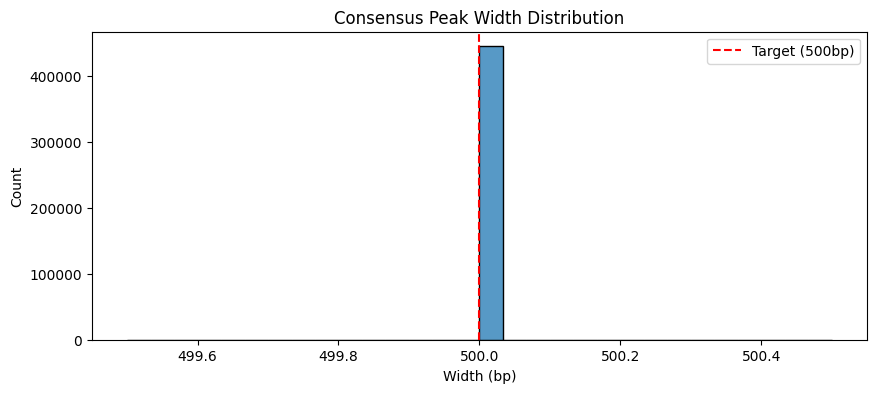

Total Peaks: 444590
Mean Width: 500.0 bp


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

df = consensus_peaks.df
df["width"] = df["End"] - df["Start"]

plt.figure(figsize=(10, 4))
sns.histplot(df["width"], bins=30)
plt.title("Consensus Peak Width Distribution")
plt.xlabel("Width (bp)")
plt.axvline(x=500, color='red', linestyle='--', label="Target (500bp)") # Change 500 if you used a different half-width
plt.legend()
plt.show()

print(f"Total Peaks: {len(df)}")
print(f"Mean Width: {df['width'].mean():.1f} bp")

Calculating contribution per sample...


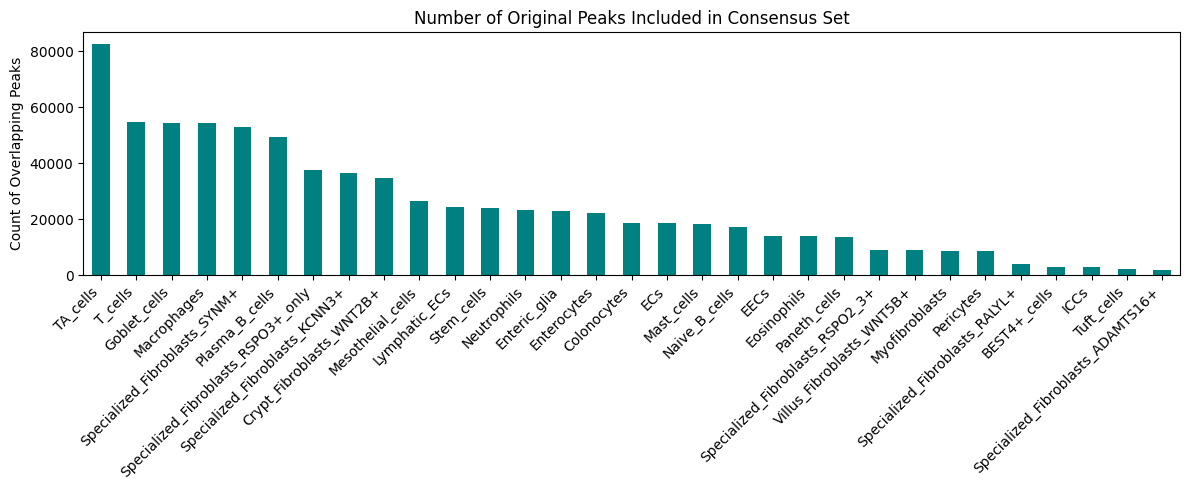

In [21]:
# Create a matrix of Peak vs Sample
# This can be slow if you have huge datasets, but fine for typical ATAC runs
counts = {}

print("Calculating contribution per sample...")
for sample, peaks_pr in narrow_peaks_dict.items():
    # Count how many of the original peaks from 'sample' overlap with the final consensus
    # keep=False avoids creating a huge dataframe, just returns the subset
    n_overlaps = len(peaks_pr.overlap(consensus_peaks))
    counts[sample] = n_overlaps

# Plot
counts_series = pd.Series(counts).sort_values(ascending=False)

plt.figure(figsize=(12, 5))
counts_series.plot(kind='bar', color='teal')
plt.title("Number of Original Peaks Included in Consensus Set")
plt.ylabel("Count of Overlapping Peaks")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
!wc -l consensus_peak_calling_Human/Consensus_Peaks_Filtered.bed

593938 consensus_peak_calling_Human/Consensus_Peaks_Filtered.bed


In [18]:
!wc -l consensus_peak_calling_Human/Consensus_Peaks_Filtered_1000.bed

401996 consensus_peak_calling_Human/Consensus_Peaks_Filtered_1000.bed


In [2]:
!ls consensus_peak_calling_Human/

Adipocytes_peaks.narrowPeak
Adipocytes_peaks.xls
Adipocytes_summits.bed
BEST4+_cells_peaks.narrowPeak
BEST4+_cells_peaks.xls
BEST4+_cells_summits.bed
Colonocytes_peaks.narrowPeak
Colonocytes_peaks.xls
Colonocytes_summits.bed
Crypt_Fibroblasts_WNT2B+_peaks.narrowPeak
Crypt_Fibroblasts_WNT2B+_peaks.xls
Crypt_Fibroblasts_WNT2B+_summits.bed
ECs_peaks.narrowPeak
ECs_peaks.xls
ECs_summits.bed
EECs_peaks.narrowPeak
EECs_peaks.xls
EECs_summits.bed
Enteric_glia_peaks.narrowPeak
Enteric_glia_peaks.xls
Enteric_glia_summits.bed
Enteric_neurons_peaks.narrowPeak
Enteric_neurons_peaks.xls
Enteric_neurons_summits.bed
Enterocytes_peaks.narrowPeak
Enterocytes_peaks.xls
Enterocytes_summits.bed
Goblet_cells_peaks.narrowPeak
Goblet_cells_peaks.xls
Goblet_cells_summits.bed
ICCs_peaks.narrowPeak
ICCs_peaks.xls
ICCs_summits.bed
ILCs_peaks.narrowPeak
ILCs_peaks.xls
ILCs_summits.bed
Lymphatic_ECs_peaks.narrowPeak
Lymphatic_ECs_peaks.xls
Lymphatic_ECs_summits.bed
MUC6+_cells_peaks.narrowPeak
MUC6+_cells_peaks.xl